Models:

- Baseline
- Regression on one-hot encoded 3-item CRT
- ML

Metrics:

- ROC AUC
- Precision-Recall AUC
- Balanced accuracy

Sections:

- Summary stats
- ML beats linear model
    - x-val
    - training
    - bootstrapped x-val
- Correlation explanation
- Intergroup difference
- Feature importance

In [1]:
import warnings
warnings.simplefilter('ignore')

import gshap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import FeatureAgglomeration
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression as LogisticRegressionBase, SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline, make_union
from sklearn.utils import resample
from tpot.builtins import StackingEstimator

import os
import random
from copy import copy
from datetime import datetime
from functools import partial

random.seed(0)
np.random.seed(0)

sns.set(color_codes=True)

PLOTS_DIR = 'plots'

## Summary statistics

In [2]:
df = pd.read_csv('CRT_clean.csv')
df.head()

,ACT,batball,3flips,widgets,trucks,lilypads,water,giftwrap,Jerry,IQ,...,school_UM (dearborn),Sex_Male,RACE_Asian,RACE_Black,RACE_Latino,RACE_Other,RACE_White,Prestige_low,Prestige_middle,CRT
0,26.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1,0,0,0,0,0,1,1,0,0.0
1,23.0,1,0.0,0.0,0.0,1.0,0.0,1.0,1.0,4.0,...,1,0,0,1,0,0,0,1,0,2.0
2,27.0,0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,4.0,...,1,1,0,0,0,0,1,1,0,1.0
3,22.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0,1,0,0,0,1,0,0.0
4,31.0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0,...,1,1,0,0,0,1,0,1,0,3.0


In [3]:
n, p = df.shape
print('Numer of observations: {}'.format(n))
print('Number of features: {}'.format(p-1)) # 1 column is the label, so # features = p-1

Numer of observations: 529
Number of features: 24


In [4]:
df[['CRT', 'ACT', 'IQ', 'Sex_Male', '3.4K v 3.8K(2)']].describe()

,CRT,ACT,IQ,Sex_Male,3.4K v 3.8K(2)
count,529.000000,529.000000,529.000000,529.000000,529.000000
mean,0.903592,26.338374,2.510397,0.504726,0.489603
std,0.973205,3.978739,2.134756,0.500451,0.500365
min,0.000000,15.000000,0.000000,0.000000,0.000000
25%,0.000000,24.000000,1.000000,0.000000,0.000000
50%,1.000000,27.000000,2.000000,1.000000,0.000000
75%,2.000000,29.000000,4.000000,1.000000,1.000000
max,3.000000,36.000000,8.000000,1.000000,1.000000


In [5]:
df[['CRT', 'ACT', 'IQ', 'Sex_Male', '3.4K v 3.8K(2)']].corr()

,CRT,ACT,IQ,Sex_Male,3.4K v 3.8K(2)
CRT,1.000000,0.477019,0.845099,0.201203,0.233242
ACT,0.477019,1.000000,0.528836,0.083374,0.190611
IQ,0.845099,0.528836,1.000000,0.268974,0.260302
Sex_Male,0.201203,0.083374,0.268974,1.000000,0.062595
3.4K v 3.8K(2),0.233242,0.190611,0.260302,0.062595,1.000000


## Model performance and comparison

In [6]:
y_var = '3.4K v 3.8K(2)'
X = df.drop(columns=y_var).to_numpy()
y = df[y_var].to_numpy()

In [7]:
class Baseline():
    def __init__(self, output=None):
        self.output = output
    
    def fit(self, X, y):
        self.output = y.mean()
        return self
        
    def predict(self, X):
        return round(self.output) * np.ones(shape=X.shape[0])
    
    def predict_proba(self, X):
        return np.ones(shape=(X.shape[0], 1)) @ np.array([[1-self.output, self.output]])
    
    def get_params(self, *args, **kwargs):
        return {'output': self.output}
    
base_clf = Baseline()

In [8]:
crt_col_idx = list(df.drop(columns=y_var).columns).index('CRT')

class LogisticRegression(LogisticRegressionBase):
    def fit(self, X, y):
        return super().fit(self._get_X(X), y)
        
    def predict(self, X):
        return super().predict(self._get_X(X))
        
    def predict_proba(self, X):
        return super().predict_proba(self._get_X(X))
    
    def _get_X(self, X):
        return X[:, crt_col_idx].reshape((-1, 1))
    
linear_clf = LogisticRegression()

In [9]:
ml_clf = make_pipeline(
    FeatureAgglomeration(affinity="euclidean", linkage="ward"),
    StackingEstimator(
        estimator=SGDClassifier(
            alpha=0.0, 
            eta0=0.1, 
            fit_intercept=False, 
            l1_ratio=0.5, 
            learning_rate="constant", 
            loss="perceptron", 
            penalty="elasticnet", 
            power_t=0.5
        )
    ),
    StackingEstimator(
        estimator=MLPClassifier(alpha=0.001, learning_rate_init=1.0)
    ),
    ExtraTreesClassifier(
        bootstrap=False, 
        criterion="entropy", 
        max_features=0.3, 
        min_samples_leaf=7, 
        min_samples_split=13, 
        n_estimators=100
    )
)

### Cross validation and training performance

In [10]:
CLASSIFIERS = [('base', base_clf), ('linear', linear_clf), ('ml', ml_clf)]
COMPARISONS = [('linear', 'base'), ('ml', 'base'), ('ml', 'linear')]
METRICS = ['accuracy', 'AUC', 'F1']

kf = KFold()

def get_xval_scores(X=X, y=y):
    xval_scores = {key: [] for key, _ in CLASSIFIERS}
    for i, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        X_train, X_test, y_train, y_test = \
            X[train_idx], X[test_idx], y[train_idx], y[test_idx]
        for key, clf in CLASSIFIERS:
            metrics = compute_metrics(clf.fit(X_train, y_train), X_test, y_test)
            xval_scores[key].append(metrics)
    return average_xval_scores(xval_scores)

def compute_metrics(clf, X, y):
    output = clf.predict_proba(X)[:,1] # probability positive class
    y_pred = output > .5
    return {
        'accuracy': accuracy_score(y, y_pred),
        'AUC': roc_auc_score(y, output),
        'F1': f1_score(y, y_pred, average='binary')
    }

def average_xval_scores(xval_scores):
    def average_metric_score(clf_key, metric):
        scores = [record[metric] for record in xval_scores[clf_key]]
        return sum(scores) / len(scores)
        
    return {
        key: {
            metric: average_metric_score(key, metric) 
            for metric in METRICS
        }
        for key, _ in CLASSIFIERS
    }

xval_scores = get_xval_scores()

In [11]:
train_scores = {
    key: compute_metrics(clf.fit(X, y), X, y)
    for key, clf in CLASSIFIERS
}

for key, _ in CLASSIFIERS:
    print('Classifier: {}'.format(key))
    for metric in METRICS:
        print('\tMetric: {}'.format(metric))
        print('\t'*2, 'Cross validation score: {:.4f}'.format(xval_scores[key][metric]))
        print('\t'*2, 'Training score: {:.4f}'.format(train_scores[key][metric]))

Classifier: base
	Metric: accuracy
		 Cross validation score: 0.4803
		 Training score: 0.5104
	Metric: AUC
		 Cross validation score: 0.5000
		 Training score: 0.5000
	Metric: F1
		 Cross validation score: 0.1192
		 Training score: 0.0000
Classifier: linear
	Metric: accuracy
		 Cross validation score: 0.5935
		 Training score: 0.5955
	Metric: AUC
		 Cross validation score: 0.6280
		 Training score: 0.6255
	Metric: F1
		 Cross validation score: 0.5577
		 Training score: 0.6137
Classifier: ml
	Metric: accuracy
		 Cross validation score: 0.6162
		 Training score: 0.6295
	Metric: AUC
		 Cross validation score: 0.6518
		 Training score: 0.7176
	Metric: F1
		 Cross validation score: 0.5763
		 Training score: 0.5702


### ROC curve on training data

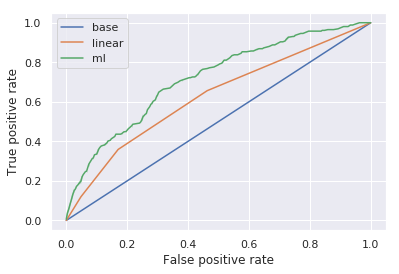

In [12]:
for key, clf in CLASSIFIERS:
    fpr, tpr, _ = roc_curve(y, clf.predict_proba(X)[:,1])
    sns.lineplot(fpr, tpr, label=key)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
if PLOTS_DIR is not None:
    plt.savefig(os.path.join(PLOTS_DIR, 'CRT_ROC.png'), bbox_inches='tight')

### Bootstrapped percent improvement

In [13]:
BOOTSTRAP_SAMPLES = 1000
start_time = datetime.now()

def compute_improvement():
    scores = get_xval_scores(*resample(X, y))
    return {
        comp: {
            metric: scores[comp[0]][metric]/scores[comp[1]][metric] - 1
            for metric in METRICS
        }
        for comp in COMPARISONS
    }

def print_improvement(improvement):
    for comp in COMPARISONS:
        print('\nComparison: {}'.format(comp))
        for metric in METRICS:
            a = np.array(improvement[comp][metric])
            print('\t'*1, 'Metric: {}'.format(metric))
            print('\t'*2, 'Average percent improvement: {:.4f}'.format(a[a < np.inf].mean()))
            print('\t'*2, 'p={:.3f}'.format((a<=0).mean()))
            print('\t'*2, '95% CI: {:.4f} {:.4f}'.format(np.quantile(a, .025), np.quantile(a, .975)))

improvement = {
    comp: {metric: [] for metric in METRICS}
    for comp in COMPARISONS
}
for i in range(BOOTSTRAP_SAMPLES):
    sample_improvement = compute_improvement()
    [
        improvement[comp][metric].append(
            sample_improvement[comp][metric]
        )
        for comp in COMPARISONS for metric in METRICS
    ]
    if i % 100 == 0:
        print('\n{:.0f}% complete'.format(100*(i+1)/BOOTSTRAP_SAMPLES))
        run_time = datetime.now() - start_time
        remaining_time = run_time / ((i+1)/BOOTSTRAP_SAMPLES) - run_time
        print('Time remaining: {}'.format(str(remaining_time)))
        # print_improvement(improvement)

print_improvement(improvement)


0% complete
Time remaining: 1:13:16.475124

10% complete
Time remaining: 1:08:04.210895

20% complete
Time remaining: 0:57:46.075583

30% complete
Time remaining: 0:49:01.523092

40% complete
Time remaining: 0:35:49.792238

50% complete
Time remaining: 0:26:23.662050

60% complete
Time remaining: 0:18:53.936332

70% complete
Time remaining: 0:12:59.106120

80% complete
Time remaining: 0:08:03.167380

90% complete
Time remaining: 0:03:46.853066

Comparison: ('linear', 'base')
	 Metric: accuracy
		 Average percent improvement: 0.1908
		 p=0.001
		 95% CI: 0.0754 0.3418
	 Metric: AUC
		 Average percent improvement: 0.2523
		 p=0.000
		 95% CI: 0.1632 0.3405
	 Metric: F1
		 Average percent improvement: 1.2590
		 p=0.128
		 95% CI: -0.1042 inf

Comparison: ('ml', 'base')
	 Metric: accuracy
		 Average percent improvement: 0.2912
		 p=0.000
		 95% CI: 0.1451 0.4700
	 Metric: AUC
		 Average percent improvement: 0.4196
		 p=0.000
		 95% CI: 0.3313 0.5046
	 Metric: F1
		 Average percent improve

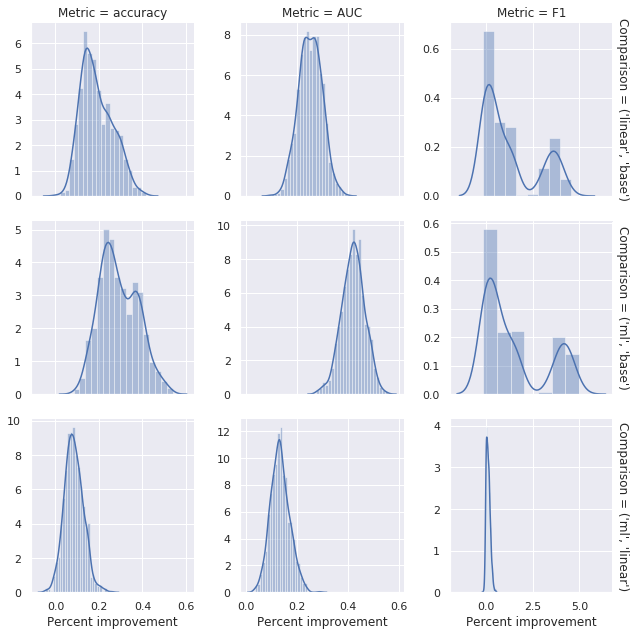

In [14]:
data = {'Sample': [], 'Comparison': [], 'Metric': [], 'PctImprovement': []}
for comp in COMPARISONS:
    for metric in METRICS:
        for i, pct_improve in enumerate(improvement[comp][metric]):
            data['Sample'].append(i)
            data['Comparison'].append(comp)
            data['Metric'].append(metric)
            data['PctImprovement'].append(pct_improve)
            
improvement_df = pd.DataFrame(data)
improvement_df.replace([np.inf, -np.inf], np.nan, inplace=True)
improvement_df.dropna(inplace=True)
g = sns.FacetGrid(improvement_df, row='Comparison', col='Metric', margin_titles=True, sharey=False, sharex='col')
g.map(sns.distplot, 'PctImprovement').set_xlabels('Percent improvement')
if PLOTS_DIR is not None:
    plt.savefig(os.path.join(PLOTS_DIR, 'CRT_comparison.png'), bbox_inches='tight')

In [15]:
base_clf.fit(X, y)
linear_clf.fit(X, y)
ml_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('featureagglomeration',
                 FeatureAgglomeration(affinity='euclidean',
                                      compute_full_tree='auto',
                                      connectivity=None,
                                      distance_threshold=None, linkage='ward',
                                      memory=None, n_clusters=2,
                                      pooling_func=<function mean at 0x7f9d8407d840>)),
                ('stackingestimator-1',
                 StackingEstimator(estimator=SGDClassifier(alpha=0.0,
                                                           average=False,
                                                           class_weight=N...
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='entropy',
                                      max_depth=None, max_features=0.3,
                                      max_l

## Correlation explanations

In [16]:
df = pd.read_csv('CRT_nodummies.csv')
X = df.drop(columns=y_var)
X_cols = [col for col in df.columns if col != y_var]

CRT_cols = ['Jerry', 'batball', 'lilypads', 'water', 'widgets', 'trucks', '3flips', 'giftwrap']
CRT = df[CRT_cols].sum(axis=1)

In [17]:
def model(X, predict_proba=False):
    X = pd.DataFrame(X, columns=X_cols)
    X = pd.get_dummies(X, columns=['school', 'Sex', 'RACE', 'Prestige'])
    X['CRT'] = X[['batball', 'widgets', 'lilypads']].sum(axis=1)
    X = X.drop(columns='Sex_Female')
    if predict_proba:
        return ml_clf.predict_proba(X)[:,1]
    return ml_clf.predict(X)

model_proba = partial(model, predict_proba=True)

### Feature importances for all variables

In [18]:
N_SAMPLES = 100

def compute_gshap(var):
    g = lambda output: np.corrcoef(output, var)[0][1]
    explainer = gshap.KernelExplainer(model_proba, X, g)
    gshap_values = explainer.gshap_values(X, nsamples=N_SAMPLES)
    return gshap_values * np.corrcoef(y, var)[0][1]

variables = (('CRT', CRT), ('ACT', df['ACT']), ('IQ', df['IQ']), ('Male', df['Sex']=='Male'))
corr_gshap_values = {key: compute_gshap(var) for key, var in variables}
corr_gshap_values['Feature'] = X_cols
corr_gshap_df = pd.DataFrame(corr_gshap_values).sort_values('CRT', ascending=False).reset_index(drop=True)
corr_gshap_df

,CRT,ACT,IQ,Male,Feature
0,0.073873,0.026030,0.073306,0.004970,IQ
1,0.055071,0.067787,0.050822,0.001417,ACT
2,0.021282,0.008214,0.021692,0.001015,lilypads
3,0.015621,0.005145,0.015594,0.000826,batball
4,0.015458,0.004680,0.015562,0.001110,widgets
5,0.009667,0.002129,0.009661,0.000792,giftwrap
6,0.009541,0.002361,0.008958,0.001311,water
7,0.009420,0.002918,0.008466,0.000452,Jerry
8,0.007583,0.002275,0.007668,0.000855,trucks
9,0.006607,0.001544,0.006039,0.000901,3flips


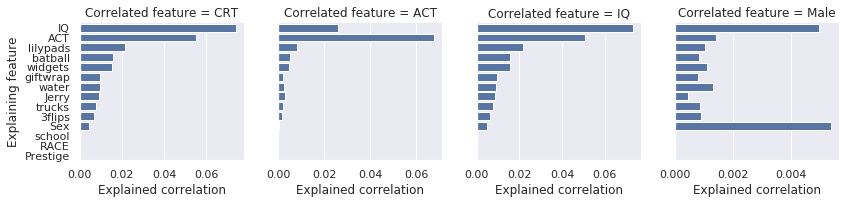

In [19]:
tmp_df = pd.melt(corr_gshap_df, id_vars='Feature', var_name='Correlated feature')
g = sns.FacetGrid(tmp_df, col='Correlated feature', sharex=False)
g.map(sns.barplot, 'value', 'Feature').set_axis_labels('Explained correlation', 'Explaining feature')
if PLOTS_DIR is not None:
    plt.savefig(os.path.join(PLOTS_DIR, 'CRT_corr_gshap.png'), bbox_inches='tight')
plt.show()

### Total correlation explained

In [20]:
corr_gshap_df.drop(columns='Feature').sum()

CRT     0.228795
ACT     0.123571
IQ      0.222731
Male    0.019057
dtype: float64

### Correlation explained by CRT items

In [21]:
corr_gshap_df[corr_gshap_df['Feature'].isin(CRT_cols)].drop(columns='Feature').sum()

CRT     0.095180
ACT     0.029268
IQ      0.093640
Male    0.007262
dtype: float64

## Performance explanations

In [22]:
N_SAMPLES = 100
COMPARISON_SAMPLES = 100
    
perf_gshap_values = {}
metrics = (
    ('accuracy', lambda output: accuracy_score(y, output > .5)),
    ('AUC', lambda output: roc_auc_score(y, output)),
    ('F1', lambda output: f1_score(y, output > .5))
)

for key, g in metrics:
    explainer = gshap.KernelExplainer(model_proba, X, g)
    gshap_values = explainer.gshap_values(X, nsamples=N_SAMPLES)
    g_comparison, g_background = explainer.compare(X, bootstrap_samples=COMPARISON_SAMPLES)
    print('\nMetric: {}'.format(key))
    print('Training performance: {:.4f}'.format(g_comparison))
    print('Performance on shuffled training data: {:.4f}'.format(g_background))
    print('Improvement over shuffled data: {:.4f}'.format(g_comparison-g_background))
    print('Sum of G-SHAP values: {:.4f}'.format(gshap_values.sum()))
    perf_gshap_values[key] = gshap_values


Metric: accuracy
Training performance: 0.6730
Performance on shuffled training data: 0.5013
Improvement over shuffled data: 0.1716
Sum of G-SHAP values: 0.1646

Metric: AUC
Training performance: 0.7400
Performance on shuffled training data: 0.5002
Improvement over shuffled data: 0.2398
Sum of G-SHAP values: 0.2396

Metric: F1
Training performance: 0.6373
Performance on shuffled training data: 0.4472
Improvement over shuffled data: 0.1902
Sum of G-SHAP values: 0.1905


In [23]:
perf_gshap_values['Feature'] = X_cols
perf_gshap_df = pd.DataFrame(perf_gshap_values).sort_values('accuracy', ascending=False).reset_index(drop=True)
perf_gshap_df

,accuracy,AUC,F1,Feature
0,0.061493,0.094550,0.071186,ACT
1,0.038998,0.053957,0.045365,IQ
2,0.013554,0.016037,0.015250,batball
3,0.013440,0.019568,0.016630,lilypads
4,0.009055,0.010936,0.010262,giftwrap
5,0.008053,0.009174,0.008538,Jerry
6,0.005236,0.007206,0.005367,widgets
7,0.004612,0.007737,0.005967,Sex
8,0.004102,0.005811,0.004164,trucks
9,0.003497,0.010148,0.005179,water


In [24]:
perf_gshap_df[perf_gshap_df['Feature'].isin(CRT_cols)].drop(columns='Feature').sum()

accuracy    0.059452
AUC         0.083405
F1          0.067992
dtype: float64

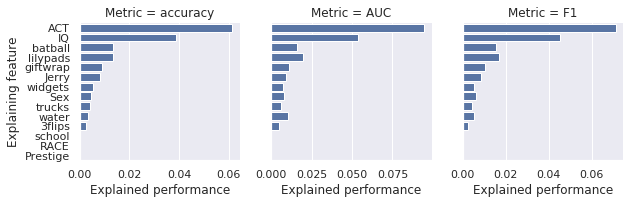

In [25]:
tmp_df = pd.melt(perf_gshap_df, id_vars='Feature', var_name='Metric')
g = sns.FacetGrid(tmp_df, col='Metric', sharex=False)
g.map(sns.barplot, 'value', 'Feature').set_axis_labels('Explained performance', 'Explaining feature')
if PLOTS_DIR is not None:
    plt.savefig(os.path.join(PLOTS_DIR, 'CRT_perf_gshap.png'), bbox_inches='tight')
plt.show()